In [1]:
from GCN_model import GCN

import torch_geometric
import torch
import numpy as np

import torch.nn as nn
import torch_geometric.datasets as datasets


import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )
print(dataset.data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


c:\Users\ckaz3\miniconda3\envs\grl_mini_project\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [3]:
def calc_aug_adj_matrix(adj_matrix: torch.Tensor, aug_adj_type: str) -> torch.Tensor:
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # calculate adjacency matrix
    num_nodes = len(adj_matrix)

    if aug_adj_type == "symmetric":
        deg_diag = torch.sum(adj_matrix, axis=1)
        deg_diag_self_loop = deg_diag + 1
        deg_diag_self_loop_inv_sq = torch.pow(deg_diag_self_loop, -0.5)
        deg_mat_self_loop_inv_sq = torch.diag(deg_diag_self_loop_inv_sq)

        aug_adj_matrix = (
            deg_mat_self_loop_inv_sq
            @ (adj_matrix + torch.eye(num_nodes).to(device))
            @ deg_mat_self_loop_inv_sq
        )
    elif aug_adj_type == "adjacency":
        aug_adj_matrix = adj_matrix.to(device)
    elif aug_adj_type == "degree":
        degree_matrix = torch.diag(torch.sum(adj_matrix, axis=1))
        aug_adj_matrix = degree_matrix
    elif aug_adj_type == "random walk":
        deg_diag = torch.sum(adj_matrix, axis=1)
        deg_diag_inv = torch.pow(deg_diag, -1)
        deg_mat_inv = torch.diag(deg_diag_inv)
        aug_adj_matrix = deg_mat_inv @ adj_matrix
    else:
        raise ValueError("Received invalid augmented adjacency matrix type.")
    
    return aug_adj_matrix

In [12]:
def evaluate(
    model: GCN,
    data: torch_geometric.data.data.Data,
    mask: torch.Tensor,
    aug_adj_type: str,
) -> torch.Tensor:
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data = dataset.data
    data = data.to(device)

    # calculate adjacency matrix
    edge_index = torch_geometric.EdgeIndex(dataset.edge_index)
    adj_matrix = edge_index.to_dense().to(device)

    aug_adj_matrix = calc_aug_adj_matrix(
        adj_matrix=adj_matrix, aug_adj_type=aug_adj_type
    )

    output = model(x=data.x, aug_adj_matrix=aug_adj_matrix)
    output = torch.argmax(output[mask], dim=1)
    target = data.y[mask]

    return torch.mean((output == target).float())

In [13]:
def train(
    num_layers: int,
    aug_adj_type: str,
    lr: int,
    weight_decay: int,
    num_epochs: int,
    dataset,
    verbose: bool = True,
) -> torch.nn.Module:
    """
    This function trains a node classification model and returns the trained model object.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    data = dataset.data
    data = data.to(device)

    # calculate adjacency matrix
    edge_index = torch_geometric.EdgeIndex(dataset.edge_index)
    adj_matrix = edge_index.to_dense().to(device)

    aug_adj_matrix = calc_aug_adj_matrix(
        adj_matrix=adj_matrix, aug_adj_type=aug_adj_type
    )

    model = GCN(
        in_channels=dataset.num_features,
        hidden_channels=64,
        out_channels=dataset.num_classes,
        num_layers=num_layers,
        dropout=0.3,
    ).to(device)

    losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    early_stop_counter = 0
    prev_val_acc = 1.1

    for i in range(num_epochs):
        optimizer.zero_grad()

        outputs = model(x=data.x, aug_adj_matrix=aug_adj_matrix)

        loss = criterion(outputs[data.train_mask], data.y[data.train_mask])
        losses.append(loss)

        loss.backward()
        optimizer.step()

        # check for early-stopping
        val_acc = evaluate(
            model=model, data=data, mask=data.val_mask, aug_adj_type=aug_adj_type
        )

        if val_acc < prev_val_acc:
            if prev_val_acc != 1.1:
                early_stop_counter += 1
            prev_val_acc = val_acc

            if early_stop_counter == 5:
                break
        else:
            prev_val_acc = 1.1
            early_stop_counter = 0

        if i % 5 == 0 and verbose:
            print(f"Epoch: {i}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")

    if verbose:
        print(f"Epoch: {i}, Loss: {loss.item():.4f}, Val Acc: {val_acc:.4f}")
    return model

In [12]:
# # # do not run

# study_data = {"symmetric": {}, "degree": {}, "adjacency": {}, "random walk": {}}

# f = open("data/results_2021.pkl", "wb")
# pickle.dump(study_data, f)
# f.close()

In [18]:
def train_seq_with_seed(seed: int):

    layers = [0, 1] 
    layers.extend(np.arange(2, 22, 2))

    with open("data/results_" + str(seed) + ".pkl", "rb") as file:
        study_data = pickle.load(file)

    for aug_adj_type in study_data:
        for num_layers in tqdm(layers):
            if num_layers in study_data[aug_adj_type]:
                continue

            print(aug_adj_type, num_layers)

            # train model
            torch.manual_seed(seed)
            np.random.seed(seed)
            
            model = train(
                num_layers=num_layers,
                aug_adj_type=aug_adj_type,
                lr=0.001,
                weight_decay=0.0001,
                num_epochs=100,
                dataset=dataset,
                verbose=False
            )

            device = "cuda" if torch.cuda.is_available() else "cpu"

            data = dataset.data
            data = data.to(device)

            test_acc = evaluate(model=model, data=data, mask=data.test_mask, aug_adj_type=aug_adj_type)

            study_data[aug_adj_type][num_layers] = test_acc
            
            f = open("data/results_" + str(seed) + ".pkl", "wb")
            pickle.dump(study_data, f)
            f.close()

In [22]:
seeds = [2021, 2022, 2023, 2024, 2025]

for seed in seeds:
    train_seq_with_seed(seed=seed)

  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\ckaz3\miniconda3\envs\grl_mini_project\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


symmetric 0


  8%|▊         | 1/12 [00:13<02:24, 13.14s/it]

symmetric 1


 17%|█▋        | 2/12 [00:31<02:44, 16.46s/it]

symmetric 2


 25%|██▌       | 3/12 [00:51<02:40, 17.79s/it]

symmetric 4


 33%|███▎      | 4/12 [01:12<02:31, 18.96s/it]

symmetric 6


 42%|████▏     | 5/12 [01:22<01:50, 15.72s/it]

symmetric 8


 50%|█████     | 6/12 [01:46<01:52, 18.78s/it]

symmetric 10


 58%|█████▊    | 7/12 [02:13<01:46, 21.35s/it]

symmetric 12


 67%|██████▋   | 8/12 [02:42<01:35, 23.81s/it]

symmetric 14


 75%|███████▌  | 9/12 [03:13<01:17, 25.97s/it]

symmetric 16


 83%|████████▎ | 10/12 [03:45<00:55, 27.79s/it]

symmetric 18


 92%|█████████▏| 11/12 [04:18<00:29, 29.48s/it]

symmetric 20


  0%|          | 0/12 [00:00<?, ?it/s]

degree 0


  8%|▊         | 1/12 [00:01<00:14,  1.35s/it]

degree 1


 17%|█▋        | 2/12 [00:09<00:50,  5.06s/it]

degree 2


 25%|██▌       | 3/12 [00:17<00:58,  6.54s/it]

degree 4


 33%|███▎      | 4/12 [00:26<01:02,  7.77s/it]

degree 6


 42%|████▏     | 5/12 [00:38<01:02,  8.95s/it]

degree 8


 50%|█████     | 6/12 [00:50<01:00, 10.13s/it]

degree 10


 58%|█████▊    | 7/12 [01:04<00:56, 11.39s/it]

degree 12


 67%|██████▋   | 8/12 [01:19<00:50, 12.62s/it]

degree 14


 75%|███████▌  | 9/12 [01:36<00:41, 13.96s/it]

degree 16


 83%|████████▎ | 10/12 [01:55<00:31, 15.56s/it]

degree 18


 92%|█████████▏| 11/12 [02:15<00:16, 16.90s/it]

degree 20


  0%|          | 0/12 [00:00<?, ?it/s]

adjacency 0


  8%|▊         | 1/12 [00:01<00:14,  1.29s/it]

adjacency 1


 17%|█▋        | 2/12 [00:08<00:49,  4.96s/it]

adjacency 2


 25%|██▌       | 3/12 [00:16<00:57,  6.38s/it]

adjacency 4


 33%|███▎      | 4/12 [00:26<01:01,  7.63s/it]

adjacency 6


 42%|████▏     | 5/12 [00:37<01:01,  8.82s/it]

adjacency 8


 50%|█████     | 6/12 [00:50<01:01, 10.19s/it]

adjacency 10


 58%|█████▊    | 7/12 [01:04<00:57, 11.59s/it]

adjacency 12


 67%|██████▋   | 8/12 [01:20<00:52, 13.07s/it]

adjacency 14


 75%|███████▌  | 9/12 [01:38<00:43, 14.44s/it]

adjacency 16


 83%|████████▎ | 10/12 [01:57<00:31, 15.86s/it]

adjacency 18


 92%|█████████▏| 11/12 [02:18<00:17, 17.50s/it]

adjacency 20


  0%|          | 0/12 [00:00<?, ?it/s]

random walk 0


  8%|▊         | 1/12 [00:06<01:14,  6.73s/it]

random walk 1


 17%|█▋        | 2/12 [00:19<01:44, 10.48s/it]

random walk 2


 25%|██▌       | 3/12 [00:33<01:47, 11.99s/it]

random walk 4


 33%|███▎      | 4/12 [00:48<01:46, 13.27s/it]

random walk 6


 42%|████▏     | 5/12 [01:05<01:40, 14.42s/it]

random walk 8


 50%|█████     | 6/12 [01:23<01:34, 15.69s/it]

random walk 10


 58%|█████▊    | 7/12 [01:42<01:24, 16.94s/it]

random walk 12


 67%|██████▋   | 8/12 [02:04<01:13, 18.27s/it]

random walk 14


 75%|███████▌  | 9/12 [02:26<00:58, 19.56s/it]

random walk 16


 83%|████████▎ | 10/12 [02:50<00:41, 20.84s/it]

random walk 18


 92%|█████████▏| 11/12 [03:16<00:22, 22.64s/it]

random walk 20


  0%|          | 0/12 [00:00<?, ?it/s]

symmetric 0


  8%|▊         | 1/12 [00:13<02:24, 13.17s/it]

symmetric 1


 17%|█▋        | 2/12 [00:32<02:48, 16.87s/it]

symmetric 2


 25%|██▌       | 3/12 [00:53<02:46, 18.47s/it]

symmetric 4


 33%|███▎      | 4/12 [01:15<02:39, 19.94s/it]

symmetric 6


 42%|████▏     | 5/12 [01:38<02:28, 21.22s/it]

symmetric 8


 50%|█████     | 6/12 [02:03<02:15, 22.60s/it]

symmetric 10


 58%|█████▊    | 7/12 [02:32<02:02, 24.44s/it]

symmetric 12


 67%|██████▋   | 8/12 [03:02<01:44, 26.20s/it]

symmetric 14


 75%|███████▌  | 9/12 [03:33<01:23, 27.93s/it]

symmetric 16


 83%|████████▎ | 10/12 [04:06<00:58, 29.40s/it]

symmetric 18


 92%|█████████▏| 11/12 [04:41<00:31, 31.00s/it]

symmetric 20


  0%|          | 0/12 [00:00<?, ?it/s]

degree 0


  8%|▊         | 1/12 [00:01<00:14,  1.34s/it]

degree 1


 17%|█▋        | 2/12 [00:08<00:50,  5.02s/it]

degree 2


 25%|██▌       | 3/12 [00:17<00:57,  6.43s/it]

degree 4


 33%|███▎      | 4/12 [00:26<01:01,  7.63s/it]

degree 6


 42%|████▏     | 5/12 [00:28<00:39,  5.71s/it]

degree 8


 50%|█████     | 6/12 [00:42<00:49,  8.28s/it]

degree 10


 58%|█████▊    | 7/12 [00:57<00:53, 10.65s/it]

degree 12


 67%|██████▋   | 8/12 [01:14<00:50, 12.65s/it]

degree 14


 75%|███████▌  | 9/12 [01:33<00:44, 14.73s/it]

degree 16


 83%|████████▎ | 10/12 [01:54<00:33, 16.70s/it]

degree 18


 92%|█████████▏| 11/12 [02:16<00:18, 18.23s/it]

degree 20


  0%|          | 0/12 [00:00<?, ?it/s]

adjacency 0


  8%|▊         | 1/12 [00:01<00:13,  1.21s/it]

adjacency 1


 17%|█▋        | 2/12 [00:08<00:50,  5.02s/it]

adjacency 2


 25%|██▌       | 3/12 [00:17<01:00,  6.69s/it]

adjacency 4


 33%|███▎      | 4/12 [00:28<01:05,  8.22s/it]

adjacency 6


 42%|████▏     | 5/12 [00:34<00:52,  7.43s/it]

adjacency 8


 50%|█████     | 6/12 [00:47<00:56,  9.47s/it]

adjacency 10


 58%|█████▊    | 7/12 [01:02<00:56, 11.35s/it]

adjacency 12


 67%|██████▋   | 8/12 [01:19<00:51, 12.94s/it]

adjacency 14


 75%|███████▌  | 9/12 [01:36<00:43, 14.46s/it]

adjacency 16


 83%|████████▎ | 10/12 [01:56<00:31, 15.98s/it]

adjacency 18


 92%|█████████▏| 11/12 [02:18<00:17, 17.74s/it]

adjacency 20


  0%|          | 0/12 [00:00<?, ?it/s]

random walk 0


  8%|▊         | 1/12 [00:06<01:13,  6.70s/it]

random walk 1


 17%|█▋        | 2/12 [00:20<01:46, 10.64s/it]

random walk 2


 25%|██▌       | 3/12 [00:33<01:48, 12.09s/it]

random walk 4


 33%|███▎      | 4/12 [00:49<01:46, 13.31s/it]

random walk 6


 42%|████▏     | 5/12 [01:06<01:43, 14.72s/it]

random walk 8


 50%|█████     | 6/12 [01:24<01:35, 16.00s/it]

random walk 10


 58%|█████▊    | 7/12 [01:44<01:26, 17.34s/it]

random walk 12


 67%|██████▋   | 8/12 [02:06<01:14, 18.57s/it]

random walk 14


 75%|███████▌  | 9/12 [02:29<00:59, 19.99s/it]

random walk 16


 83%|████████▎ | 10/12 [02:53<00:42, 21.34s/it]

random walk 18


 92%|█████████▏| 11/12 [03:19<00:22, 22.81s/it]

random walk 20


  0%|          | 0/12 [00:00<?, ?it/s]

symmetric 12


 67%|██████▋   | 8/12 [00:27<00:13,  3.47s/it]

symmetric 14


 75%|███████▌  | 9/12 [00:58<00:22,  7.55s/it]

symmetric 16


 83%|████████▎ | 10/12 [01:30<00:24, 12.01s/it]

symmetric 18


 92%|█████████▏| 11/12 [02:05<00:16, 16.60s/it]

symmetric 20


  0%|          | 0/12 [00:00<?, ?it/s]

degree 0


  8%|▊         | 1/12 [00:01<00:13,  1.25s/it]

degree 1


 17%|█▋        | 2/12 [00:09<00:55,  5.50s/it]

degree 2


 25%|██▌       | 3/12 [00:18<01:03,  7.09s/it]

degree 4


 33%|███▎      | 4/12 [00:29<01:08,  8.57s/it]

degree 6


 42%|████▏     | 5/12 [00:35<00:53,  7.63s/it]

degree 8


 50%|█████     | 6/12 [00:48<00:57,  9.62s/it]

degree 10


 58%|█████▊    | 7/12 [01:04<00:57, 11.53s/it]

degree 12


 67%|██████▋   | 8/12 [01:21<00:53, 13.31s/it]

degree 14


 75%|███████▌  | 9/12 [01:40<00:45, 15.12s/it]

degree 16


 83%|████████▎ | 10/12 [02:01<00:33, 16.77s/it]

degree 18


 92%|█████████▏| 11/12 [02:23<00:18, 18.36s/it]

degree 20


  0%|          | 0/12 [00:00<?, ?it/s]

adjacency 0


  8%|▊         | 1/12 [00:01<00:12,  1.13s/it]

adjacency 1


 17%|█▋        | 2/12 [00:08<00:49,  4.91s/it]

adjacency 2


 25%|██▌       | 3/12 [00:16<00:56,  6.33s/it]

adjacency 4


 33%|███▎      | 4/12 [00:26<01:00,  7.61s/it]

adjacency 6


 42%|████▏     | 5/12 [00:37<01:01,  8.83s/it]

adjacency 8


 50%|█████     | 6/12 [00:49<01:00, 10.11s/it]

adjacency 10


 58%|█████▊    | 7/12 [01:03<00:56, 11.38s/it]

adjacency 12


 67%|██████▋   | 8/12 [01:19<00:51, 12.75s/it]

adjacency 14


 75%|███████▌  | 9/12 [01:36<00:42, 14.08s/it]

adjacency 16


 83%|████████▎ | 10/12 [01:43<00:24, 12.03s/it]

adjacency 18


 92%|█████████▏| 11/12 [02:06<00:15, 15.12s/it]

adjacency 20


  0%|          | 0/12 [00:00<?, ?it/s]

random walk 0


  8%|▊         | 1/12 [00:06<01:16,  6.94s/it]

random walk 1


 17%|█▋        | 2/12 [00:20<01:48, 10.85s/it]

random walk 2


 25%|██▌       | 3/12 [00:34<01:51, 12.43s/it]

random walk 4


 33%|███▎      | 4/12 [00:39<01:15,  9.42s/it]

random walk 6


 42%|████▏     | 5/12 [00:56<01:25, 12.18s/it]

random walk 8


 50%|█████     | 6/12 [01:16<01:27, 14.64s/it]

random walk 10


 58%|█████▊    | 7/12 [01:37<01:24, 16.98s/it]

random walk 12


 67%|██████▋   | 8/12 [02:01<01:16, 19.14s/it]

random walk 14


 75%|███████▌  | 9/12 [02:26<01:02, 20.89s/it]

random walk 16


 83%|████████▎ | 10/12 [02:54<00:45, 23.00s/it]

random walk 18


 92%|█████████▏| 11/12 [03:22<00:24, 24.72s/it]

random walk 20


100%|██████████| 12/12 [00:00<?, ?it/s]


In [30]:
np.ones(5) + np.array([1, 2, 3, 4])

ValueError: operands could not be broadcast together with shapes (5,) (4,) 

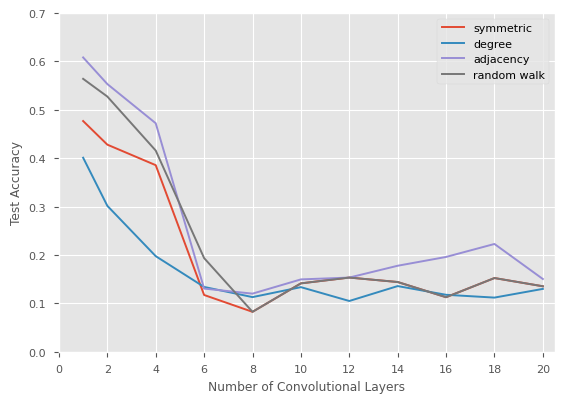

In [70]:
plotting_data = []

for seed in seeds:
    with open("data/results_" + str(seed) + ".pkl", "rb") as file:
        plotting_data.append(pickle.load(file))


types = list(plotting_data[0].keys())
layer_tests = list(plotting_data[0]["symmetric"].keys())[1:]

plt.style.use("seaborn-v0_8-paper")

for type in types:
    series = np.zeros(len(layer_tests))

    for i, _ in enumerate(seeds):
        series += np.array(
            [plotting_data[i][type][num_layers].cpu() for num_layers in layer_tests]
        )
    
    series /= len(seeds)
    
    plt.plot(
        layer_tests, series, label=type
    )

plt.xlabel("Number of Convolutional Layers")
plt.ylabel("Test Accuracy")
plt.ylim(0, 0.7)
plt.xlim(0, 20.5)
plt.xticks(np.arange(0, 22, 2))
plt.legend()
plt.show()